# RISK ANALYSIS AND CREDIT GRANT

## SOLUTION PLANNING

### INPUT
Problemas de Negócio:
- Como garantir que o crédito seja concedido de forma responsável, minimizando o risco de inadimplência?

- Quais clientes são mais propensos a serem aprovados para um aumento de crédito com base em seu histórico e perfil financeiro?

- Como ajustar o limite de crédito oferecido de maneira proporcional ao perfil de risco e ao potencial de lucro da instituição financeira?

Contexto dos Dados:

Os dados de clientes incluem informações demográficas, histórico de crédito, renda anual, utilização de crédito, comportamento de pagamento e número de contas bancárias. Esse conjunto de dados é analisado para prever a elegibilidade de clientes para autorização e um aumento de crédito.



### OUTPUT

Relatório com as Respostas para as Perguntas de Negócio:

1 . Quem são os clientes elegíveis para um aumento de crédito?

- Clientes que têm um histórico de pagamentos consistente, alta pontuação de crédito e um bom equilíbrio entre renda e dívidas.

2 . Quantos clientes serão autorizados para receber um aumento de crédito?

- Estimativa de quantos clientes, com base nas previsões do modelo de classificação, terão o aumento de crédito aprovado.

3 . Quais são as principais características desses clientes?

- Perfil financeiro sólido: Baixa proporção de inadimplência, alta pontuação de crédito e menor taxa de utilização de crédito.

- Características comportamentais: maior renda, investimento mensal positivo e bom histórico de crédito.

4 . Qual a expectativa de retorno financeiro desses clientes com o aumento de crédito?

- Estimativa de receita adicional com base nas taxas de juros cobradas e no aumento de limite, utilizando modelos de previsão financeira (como ARIMA).

5 . Quais são as condições para um cliente ser autorizado para aumento de crédito?

- Critérios definidos a partir de análise de risco, incluindo pontuação de crédito mínima, comportamento de pagamento e proporção da dívida sobre a renda.

6 . Quais são as condições para um cliente ser recusado ou removido da lista de aumento de crédito?

- Clientes com histórico de pagamentos atrasados frequentes, alta relação entre dívida e renda ou baixa pontuação de crédito podem ser recusados ou removidos do programa de aumento.

7 . Como garantir a eficácia do modelo de concessão de crédito?

Validação do modelo com testes A/B e análise de impacto financeiro, para medir o aumento da receita e o controle do risco de inadimplência.
Quais ações o time de marketing pode realizar para maximizar o retorno financeiro e engajamento?

Oferecer incentivos para clientes aprovados, como taxas de juros reduzidas temporárias, programas de fidelidade ou vantagens exclusivas de compra para aumentar o uso do crédito e a retenção.
TAREFAS
Quem são os clientes elegíveis para o aumento de crédito?

Definir os critérios de elegibilidade com base em dados como pontuação de crédito, relação entre dívida e renda e comportamento de pagamento.
Análise exploratória e segmentação para identificar grupos de risco baixo.
Quantos clientes farão parte do grupo aprovado?

Estimar a proporção de clientes autorizados com base na taxa de aprovação definida pelo modelo de classificação.
Quais as principais características dos clientes elegíveis?

Analisar os dados demográficos (idade, ocupação, salário) e comportamento de crédito (histórico de pagamentos, número de contas, dívidas ativas).
Qual a contribuição esperada desses clientes para o crescimento financeiro?

Utilizar previsões de receita com base nas taxas de juros aplicadas ao novo limite de crédito concedido.
Quais as condições para um cliente ser aprovado ou recusado?

Definir um limiar de aprovação com base na pontuação de crédito, análise de perfil e risco.
Como garantir a eficácia da solução?

Realizar validação do modelo com cross-validation e testes estatísticos para garantir a precisão das previsões.
Quais estratégias podem ser implementadas para aumentar a utilização de crédito dos clientes autorizados?

Implementar campanhas de marketing focadas em benefícios adicionais para os clientes aprovados, como descontos exclusivos ou redução temporária de juros.

# 1.0 - IMPORTS


## 1.1 - LIBRARIES

In [109]:
import pandas                   as pd
import numpy                    as np
import inflection
import matplotlib.pyplot        as plt
import seaborn                  as sns
import plotly.express           as px
import re
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection    import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.linear_model       import LogisticRegression
from boruta                     import BorutaPy
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer

## 1.2 - LOAD DATA

In [110]:
df_raw = pd.read_csv('../dataset/credit_analysis.csv')

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [111]:
sns.set_theme(rc = {'figure.figsize':(13,5)})


### 1.3.2 - OUTLIERS VOLUMETRY

In [112]:
def outliers_volumetry(data):
    
    df_num = pd.DataFrame()
    df_num = data.select_dtypes(exclude = 'object')
    outlier = []

    for i in df_num.columns:
        q1 = np.quantile(df_num[i], 0.25)
        q3 = np.quantile(df_num[i], 0.75)
        interquartile_distance = q3 - q1
        upper_limit = q3 + 1.5 * interquartile_distance
        lower_limit = q1 - 1.5 * interquartile_distance
        outliers = 0
        for j in df_num.index:
            if df_num[i][j] > upper_limit:
                outliers = outliers + 1
            elif df_num[i][j] < lower_limit:
                outliers = outliers + 1
            else:
                pass

        outlier.append(outliers)

    df_outlier = pd.DataFrame()
    df_outlier['attributes']    = df_num.columns
    df_outlier['quantity']      =   outlier
    df_outlier['percentual']    =   (outlier/df_num['customer_id'].count())*100
    df_outlier['percentual'] = df_outlier['percentual'].apply(lambda x: f"{x:.2f}%")

    return df_outlier    

# 2.0 - DATA DESCRIPTION

In [113]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSION

In [114]:
print('Number of Rows: {}'.format(df2.shape[0]))
print('Number of Columns: {}'.format(df2.shape[1]))
print('Number of unique features')
df2.apply(lambda x: x.nunique())

Number of Rows: 100000
Number of Columns: 26
Number of unique features


Unnamed: 0             100000
customer id             12500
day month                   8
age                        43
occupation                 15
annual salary           12488
num bank accounts          12
cards num                  12
loan interest              34
num loans                  10
days late payment          63
qtd late payments          26
credit checks              18
credit mix                  3
total debt              12203
credit usage fee       100000
credit history age        404
monthly investment      12261
payment behavior            6
final balance month     98494
credit score                3
car loan                    2
home loan                   2
personal loan               2
credit loan                 2
student loan                2
dtype: int64

## 2.2 - RENAME COLUMNS

In [115]:
df2.columns

Index(['Unnamed: 0', 'customer id', 'day month', 'age', 'occupation',
       'annual salary', 'num bank accounts', 'cards num', 'loan interest',
       'num loans', 'days late payment', 'qtd late payments', 'credit checks',
       'credit mix', 'total debt', 'credit usage fee', 'credit history age',
       'monthly investment', 'payment behavior', 'final balance month',
       'credit score', 'car loan', 'home loan', 'personal loan', 'credit loan',
       'student loan'],
      dtype='object')

In [116]:
df2 = df2.drop(columns = {'Unnamed: 0'}, axis=1)


In [117]:
def to_snake_case(column_name):
    # Substituir espaços por underscores
    column_name = column_name.replace(' ', '_')
    # Colocar um sublinhado antes das letras maiúsculas e converter para minúsculas
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Atualizando os nomes das colunas no DataFrame
old_columns = df2.columns
new_columns = [to_snake_case(col) for col in old_columns]
df2.columns = new_columns

# Verificando o resultado final
df2.columns

Index(['customer_id', 'day_month', 'age', 'occupation', 'annual_salary',
       'num_bank_accounts', 'cards_num', 'loan_interest', 'num_loans',
       'days_late_payment', 'qtd_late_payments', 'credit_checks', 'credit_mix',
       'total_debt', 'credit_usage_fee', 'credit_history_age',
       'monthly_investment', 'payment_behavior', 'final_balance_month',
       'credit_score', 'car_loan', 'home_loan', 'personal_loan', 'credit_loan',
       'student_loan'],
      dtype='object')

## 2.3 - DATA TYPES

In [118]:
df2.dtypes

customer_id              int64
day_month                int64
age                    float64
occupation              object
annual_salary          float64
num_bank_accounts      float64
cards_num              float64
loan_interest          float64
num_loans              float64
days_late_payment      float64
qtd_late_payments      float64
credit_checks          float64
credit_mix              object
total_debt             float64
credit_usage_fee       float64
credit_history_age     float64
monthly_investment     float64
payment_behavior        object
final_balance_month    float64
credit_score            object
car_loan                 int64
home_loan                int64
personal_loan            int64
credit_loan              int64
student_loan             int64
dtype: object

In [119]:
df2['age'] = df2['age'].astype(int)

## 2.4 - NA VOLUMETRY

In [120]:
df2.isna().sum()

customer_id            0
day_month              0
age                    0
occupation             0
annual_salary          0
num_bank_accounts      0
cards_num              0
loan_interest          0
num_loans              0
days_late_payment      0
qtd_late_payments      0
credit_checks          0
credit_mix             0
total_debt             0
credit_usage_fee       0
credit_history_age     0
monthly_investment     0
payment_behavior       0
final_balance_month    0
credit_score           0
car_loan               0
home_loan              0
personal_loan          0
credit_loan            0
student_loan           0
dtype: int64

## 2.5 - OUTLIER VOLUMETRY

In [121]:
outliers_volumetry(df2)

,attributes,quantity,percentual
0,customer_id,0,0.00%
1,day_month,0,0.00%
2,age,0,0.00%
3,annual_salary,2000,2.00%
4,num_bank_accounts,0,0.00%
5,cards_num,0,0.00%
6,loan_interest,0,0.00%
7,num_loans,0,0.00%
8,days_late_payment,4002,4.00%
9,qtd_late_payments,0,0.00%


# 3.0 - DESCRIPTIVE STATISTICAL

In [122]:
df3 = df2.copy()

In [123]:
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df3.select_dtypes(include = 'object')

In [124]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,customer_id,1006.00000,50999.000000,49993.000000,25982.666640,25777.000000,14340.471348,0.011057,-1.187935
1,day_month,1.00000,8.000000,7.000000,4.500000,4.500000,2.291288,0.000000,-1.238097
2,age,14.00000,56.000000,42.000000,33.316340,33.000000,10.764758,0.156338,-0.926811
3,annual_salary,7005.93000,179987.280000,172981.350000,50505.123449,36999.705000,38299.230595,1.130223,0.608152
4,num_bank_accounts,0.00000,11.000000,11.000000,5.368820,5.000000,2.593301,-0.190015,-0.691922
5,cards_num,0.00000,11.000000,11.000000,5.533570,5.000000,2.067088,0.225808,-0.327834
6,loan_interest,1.00000,34.000000,33.000000,14.532080,13.000000,8.741287,0.496232,-0.681877
7,num_loans,0.00000,9.000000,9.000000,3.532880,3.000000,2.446344,0.445609,-0.614525
8,days_late_payment,0.00000,62.000000,62.000000,21.081410,18.000000,14.804486,0.969840,0.324643
9,qtd_late_payments,0.00000,25.000000,25.000000,13.313120,14.000000,6.237135,-0.214470,-0.703200


# 4.0 - FEATURE ENGINEERING

In [125]:
df4 = df3.copy()

## 4.1 - RAZÕES E PROPORÇÕES

**Razões e Proporções**
- **Identificação de Clientes de Alto Risco**: Clientes com uma alta proporção de empréstimos podem ser sinalizados como de alto risco, ajudando a prevenir inadimplência.

- **Segmentação de Clientes:** A instituição pode usar essa métrica para segmentar clientes em diferentes categorias de risco e personalizar ofertas de crédito.

- **Melhoria da Precisão do Modelo:** Adicionar essa feature ao modelo de classificação pode melhorar sua capacidade de prever quem deve receber um aumento de crédito, considerando a dependência do cliente em relação aos empréstimo.

**Proporção de credito**

Ajuda a entender a relação entre o número de empréstimos e o número de contas bancárias, indicando a dependência do cliente em relação a empréstimos.

In [126]:
df4['proportion_loans'] = df4.apply(lambda x: x['num_loans'] / x['num_bank_accounts'] if x['num_bank_accounts'] != 0 else 0, axis=1)

In [127]:
df4['proportion_loans'].isna().sum()

np.int64(0)

**Proporção de dívidas sobre salário**

Indica a carga da dívida em relação à capacidade financeira do cliente, importante para avaliar o risco de crédito.

In [128]:
df4['salary_debt_ratio'] = df4['total_debt'] / df4['annual_salary']
df4['salary_debt_ratio'].isna().sum()

np.int64(0)

**Proporção de inadimplência**

Avalia a frequência de atrasos em pagamentos em relação ao número total de empréstimos, importante para identificar clientes de alto risco.

In [129]:
df4['delinquency_ratio'] = df4.apply(lambda x: x['qtd_late_payments'] / x['num_loans'] if x['num_loans'] != 0 else 0, axis=1)
df4['delinquency_ratio'].isna().sum()

np.int64(0)

**Proporção de investimentos sobre salário**

Indica a propensão do cliente a investir uma parte de sua renda mensal, mostrando um comportamento financeiro responsável.

In [130]:
df4['salary_investment_proportion'] = df4['monthly_investment'] / (df4['annual_salary'] / 12)
df4['salary_investment_proportion'].isna().sum()

np.int64(0)

**Impacto do Crédito** 

Combina dívida total com saldo final do mês e salário anual para fornecer uma medida composta da situação financeira do cliente.

In [131]:
df4['credit_impact'] = df4['total_debt'] / (df4['annual_salary'] + df4['final_balance_month'])
df4['credit_impact'].isna().sum()

np.int64(0)

## 4.2 - AGREGAÇÕES

**Total de empréstimos pendentes**

Soma de todos os tipos de empréstimos, fornecendo uma visão geral da carga de empréstimos do cliente.

In [132]:
df4['total_loans'] = df4['car_loan'] + df4['home_loan'] + df4['personal_loan'] + df4['credit_loan'] + df4['student_loan']
df4['total_loans'].isna().sum()

np.int64(0)

**Média de juros de empréstimos** 

Média dos juros pagos pelos empréstimos, importante para avaliar o custo médio do crédito do cliente 

In [133]:
df4['average_interest_loans'] = df4['loan_interest'] / df4['total_loans']
max_value = df4.loc[df4['average_interest_loans'] != np.inf, 'average_interest_loans'].max()
df4['average_interest_loans'] = df4['average_interest_loans'].replace(np.inf, max_value)
print(df4['average_interest_loans'].isna().sum())


0


## 4.3 - CLASSES E CATEGORIAS

**Faixa Etária** 

Agrupa clientes em categorias de idade, permitindo analisar comportamentos financeiros específicos de cada faixa etária.

In [134]:
df4['age_group']= pd.cut(df4['age'], bins=[0, 25, 35, 45, 55, 65, 75, 100], labels=['0-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-100'])
df4['age_group'].isna().sum()

np.int64(0)

**Faixa Salarial**

Agrupa clientes em categorias de salário, ajudando a entender comportamentos financeiros relativos a diferentes níveis de renda.

In [135]:
df4['salary_group'] = pd.cut(df4['annual_salary'], bins=[0, 20000, 40000, 60000, 80000, 100000, 200000, 500000], labels=['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-200k', '200k+'])
df4['salary_group'].isna().sum()

np.int64(0)

**Autorização de Crédito**

- **Automatiza Decisões**: Permite automatizar e agilizar a decisão sobre a concessão de crédito.

- **Padroniza o Processo**: Define critérios claros para avaliar se um cliente está apto a receber crédito, reduzindo a subjetividade.

- **Reduz Riscos**: Ajuda a controlar o risco de inadimplência ao conceder crédito apenas a clientes que atendem a critérios específicos.

- **Facilita Análises**: Permite analisar o desempenho das decisões de crédito ao longo do tempo para ajustes e melhorias.

- **Garante Compliance**: Ajuda a cumprir regulamentações e normas aplicáveis, garantindo transparência e consistência nas decisões.

In [136]:
# Exemplo de criação da feature "authorized"
def authorized(row):
    if row['credit_score'] == 'Good':
        if(row['qtd_late_payments'] <= 1 and
           row['credit_checks'] < 1 and
           row['days_late_payment'] < 7 and
           row['credit_history_age'] > 365 and
           row['total_debt'] < 0.5 * row['annual_salary']):
            return 'authorized'
        
    elif row['credit_score'] == 'Standard':
        if(row['qtd_late_payments'] <= 3 and
           row['credit_checks'] < 2 and
           row['days_late_payment'] < 15 and
           row['credit_history_age'] > 180 and
           row['total_debt'] < 0.4 * row['annual_salary']):
            return 'authorized'
            
        return 'authorized'
    
    # Se não atender aos critérios acima, não está autorizado
    return 'not authorized'

# Aplicar a função para criar a coluna 'authorized'
df4['status'] = df4.apply(authorized, axis=1)

# Exibir o DataFrame com a nova coluna
print(df4['credit_score'].value_counts(normalize=True))
print('\nProporção de concessão: \n{}'.format(df4['status'].value_counts(normalize = True)))
print('\nQuantidade de dados NAN: {}'.format(df4['credit_score'].isna().sum()))


credit_score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64

Proporção de concessão: 
status
authorized        0.53193
not authorized    0.46807
Name: proportion, dtype: float64

Quantidade de dados NAN: 0


## 4.4 - DATATYPES

In [137]:
df4.dtypes

customer_id                        int64
day_month                          int64
age                                int64
occupation                        object
annual_salary                    float64
num_bank_accounts                float64
cards_num                        float64
loan_interest                    float64
num_loans                        float64
days_late_payment                float64
qtd_late_payments                float64
credit_checks                    float64
credit_mix                        object
total_debt                       float64
credit_usage_fee                 float64
credit_history_age               float64
monthly_investment               float64
payment_behavior                  object
final_balance_month              float64
credit_score                      object
car_loan                           int64
home_loan                          int64
personal_loan                      int64
credit_loan                        int64
student_loan    

**Função para converter variaveis do tipo float para int, e atualizar o numero de casas decimais de uma variavel float**

In [138]:
def convert_int(col):
    return col.astype(int)

def decimal_space(col):
    return np.around(col, 2)

In [139]:
df4['num_bank_accounts']    = convert_int(df4['num_bank_accounts'])
df4['cards_num']            = convert_int(df4['cards_num'])
df4['loan_interest']        = convert_int(df4['loan_interest'])
df4['days_late_payment']    = convert_int(df4['days_late_payment'])
df4['qtd_late_payments']    = convert_int(df4['qtd_late_payments'])
df4['credit_checks']        = convert_int(df4['credit_checks'])
df4['credit_history_age']   = convert_int(df4['credit_history_age'])


In [140]:
df4['annual_salary']                = decimal_space(df4['annual_salary'])
df4['credit_usage_fee']             = decimal_space(df4['credit_usage_fee'])
df4['monthly_investment']           = decimal_space(df4['monthly_investment'])
df4['final_balance_month']          = decimal_space(df4['final_balance_month'])
df4['proportion_loans']             = decimal_space(df4['proportion_loans'])
df4['salary_debt_ratio']            = decimal_space(df4['salary_debt_ratio'])
df4['delinquency_ratio']            = decimal_space(df4['delinquency_ratio'])
df4['salary_investment_proportion'] = decimal_space(df4['salary_investment_proportion'])
df4['credit_impact']                = decimal_space(df4['credit_impact'])

## 4.5 - DROP EXTRA COLUMNS

In [141]:
df4 = df4.drop(columns = ['day_month', 'credit_mix','payment_behavior', 'car_loan', 'home_loan', 'personal_loan', 'credit_loan',
       'student_loan', 'num_loans'])

# 5.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [142]:
df5 = df4.copy()

## 5.1 - UNIVARIATE ANALYSIS

### 5.1.1 - OVERVIEW FREQUENCY

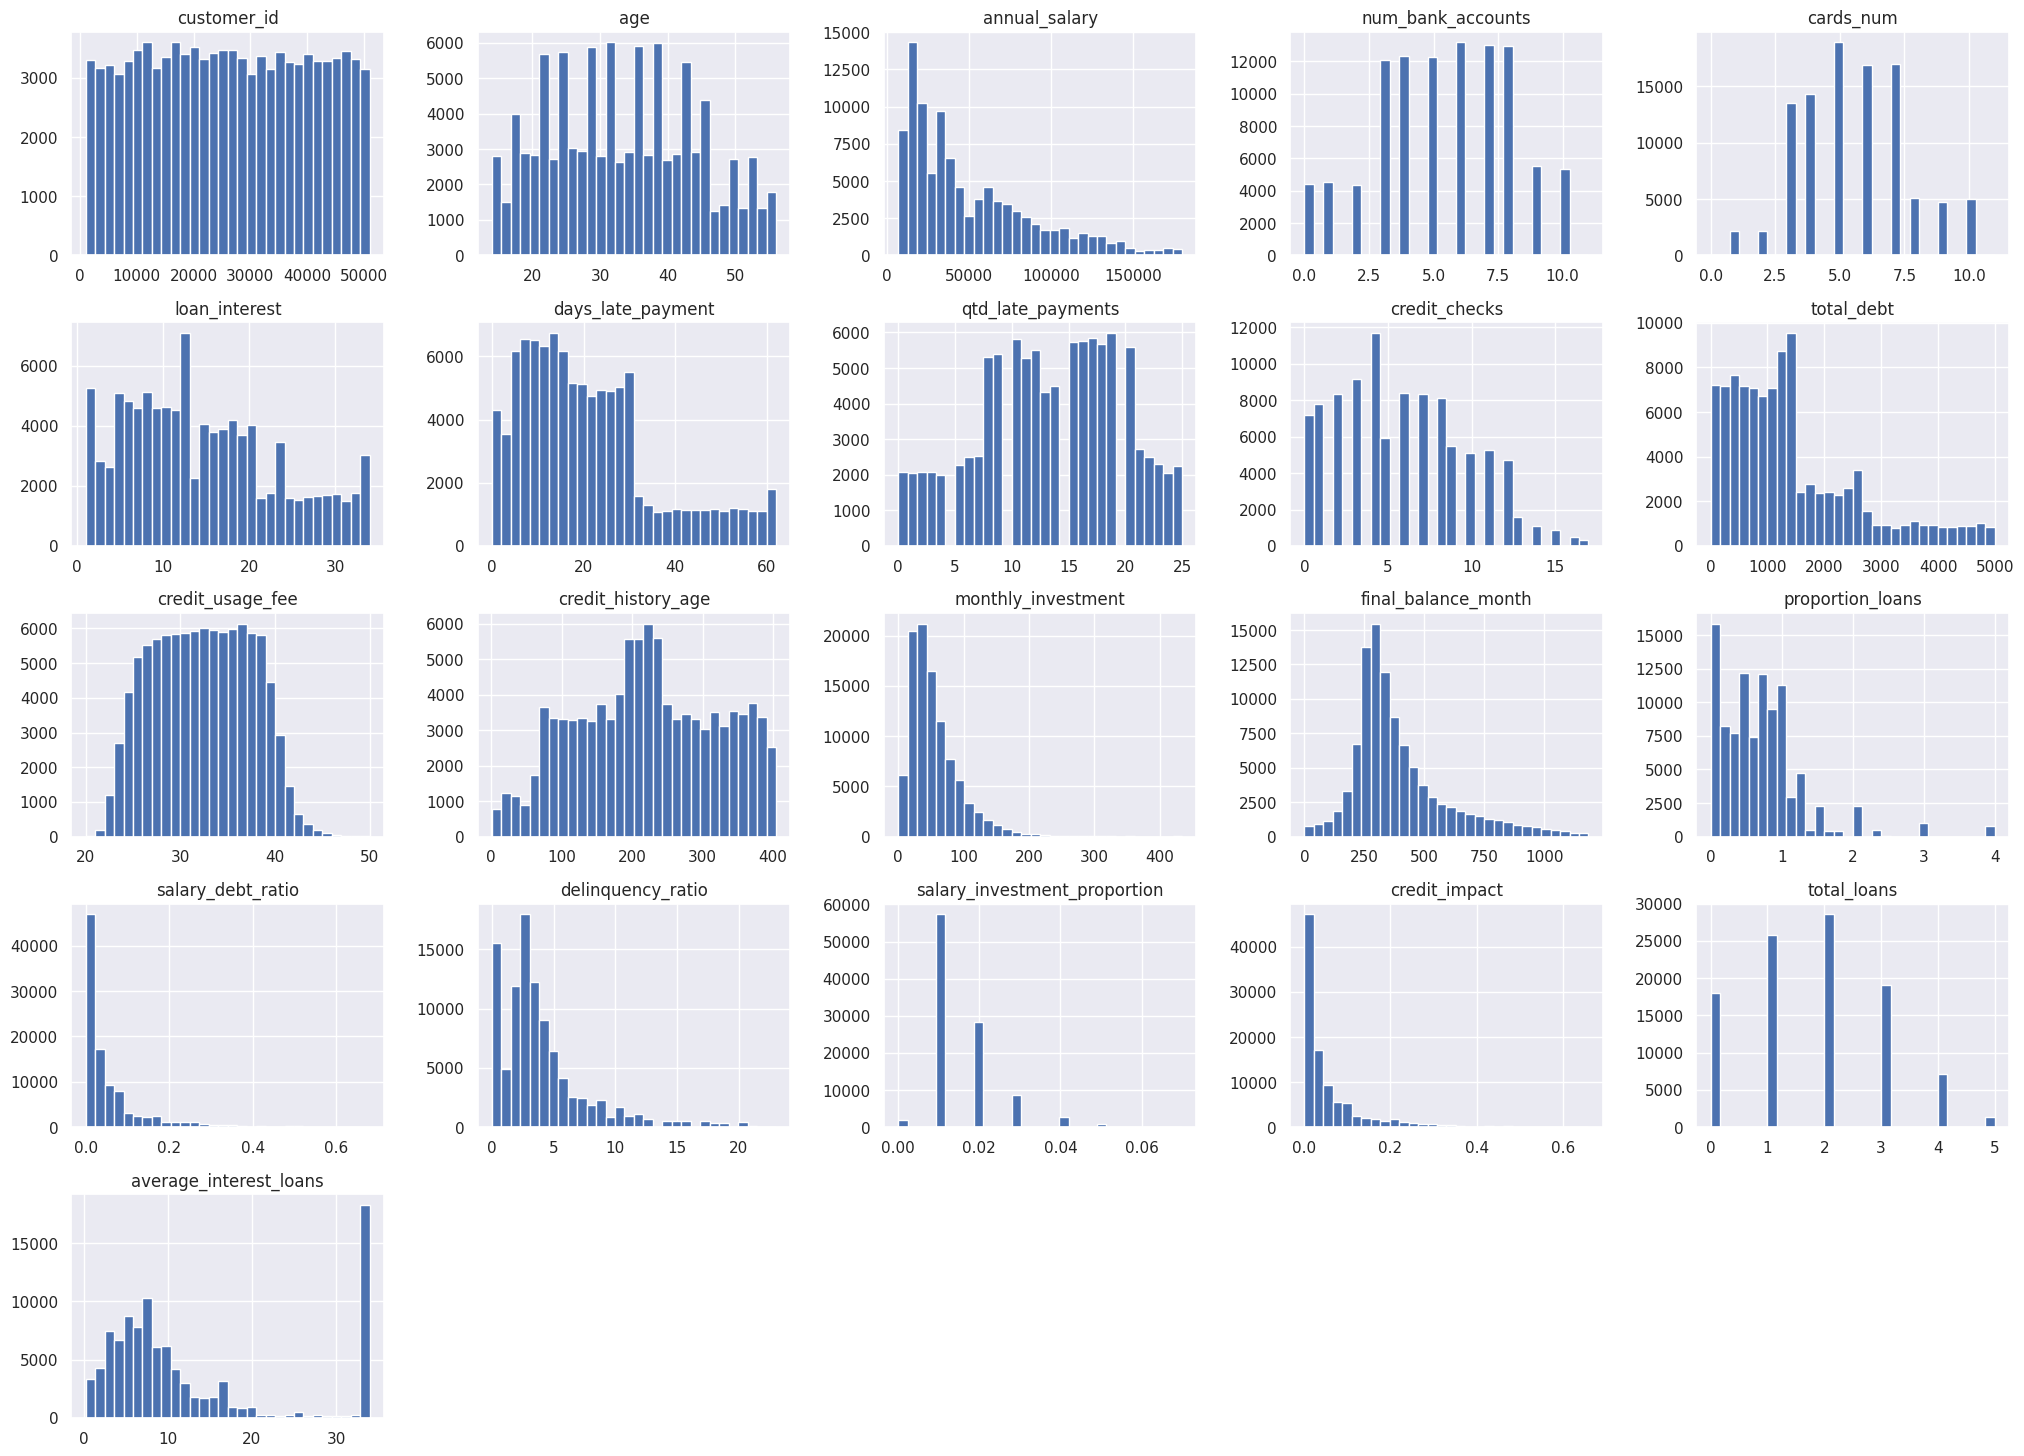

In [143]:
df5.hist(figsize=(25,18), bins = 30)
plt.show()

### 5.1.2 - VOLUMETRY SCORE

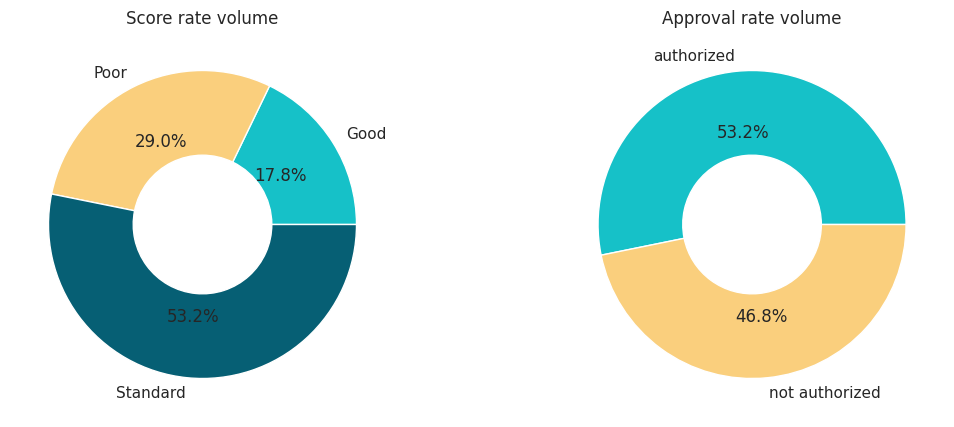

In [144]:
plt.subplot(1,2,1)
colors = ["#16c1c8", "#facf7d", "#065f74"]
aux = df5[['credit_score', 'customer_id']].groupby('credit_score').count().reset_index()
plt.pie(aux['customer_id'], labels = aux['credit_score'], autopct='%1.1f%%', wedgeprops=dict(width=0.55), colors = colors)
plt.title('Score rate volume')

plt.subplot(1,2,2)
aux1 = df5[['status', 'customer_id']].groupby('status').count().reset_index()
plt.pie(aux1['customer_id'], labels = aux1['status'], autopct='%1.1f%%', wedgeprops=dict(width=0.55), colors = colors)
plt.title('Approval rate volume')

plt.show()

### 5.1.3 - CUSTOMER VOLUMETRY

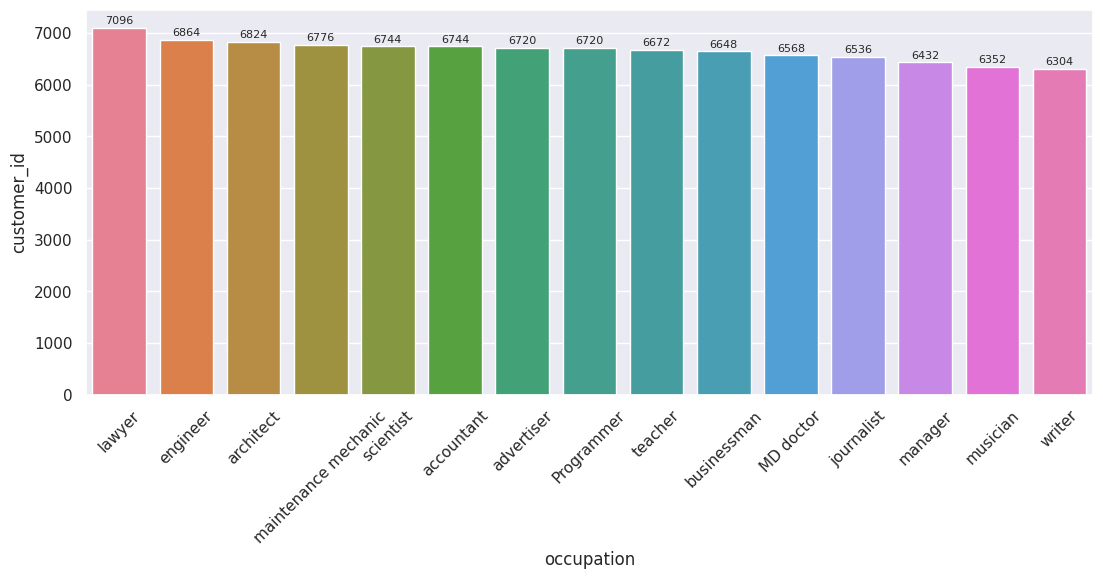

In [145]:
aux = df5[['customer_id', 'occupation']].groupby(['occupation']).count().reset_index().sort_values('customer_id', ascending = False)
barplot = sns.barplot(data = aux, x = aux['occupation'], y = aux['customer_id'], hue = 'occupation')
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
plt.xticks(rotation = 45)
plt.show()

## 5.2 - BIVARIATE ANALYSIS

### 5.2.1 FEATURE CORRELATION

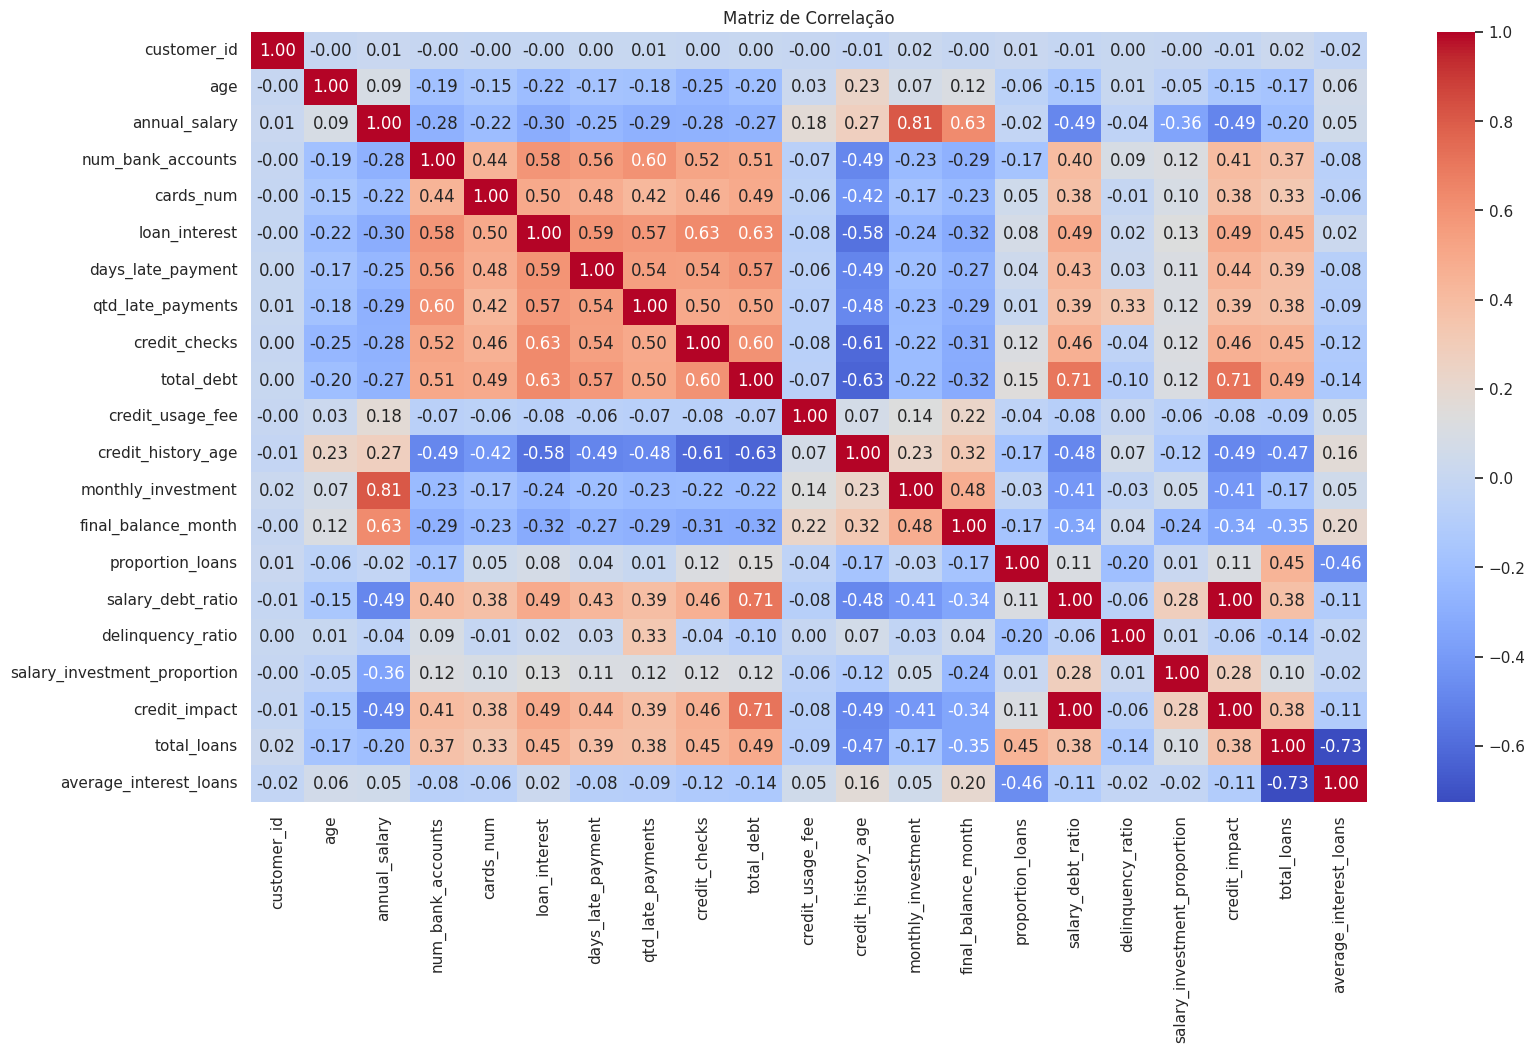

In [146]:
# Matriz de correlação
df_numeric = df5.select_dtypes(exclude=['object', 'category'])
plt.figure(figsize=(18, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


## 5.2 - MULTIVARIATE ANALYSIS

# 6.0 - DATA PREPARATION


In [147]:
df6 = df5.copy()
df6 = df6.drop(columns = ['customer_id','age_group', 'salary_group'])

## 6.1 - ONE HOT ENCODER

In [148]:
df6['status'] = df6['status'].map({'not authorized': 0, 'authorized': 1})
df6['status'] = df6['status'].astype(int)


## 6.2 - ORDINARY ENCODER

In [149]:
dict_score = {'Good':3, 'Standard':2, 'Poor':1}
df6['credit_score'] = df6['credit_score'].map(dict_score)
df6['credit_score'] = df6['credit_score'].astype(int)

## 6.3 - LABEL ENCODER

In [150]:
le = LabelEncoder()
df6['occupation'] = le.fit_transform(df6['occupation'])

## 6.4 - STANDART SCALER

In [151]:
rs = RobustScaler()
df6['annual_salary'] = rs.fit_transform(df6[['annual_salary']])

In [152]:
std = StandardScaler()

#df6['annual_salary'] = std.fit_transform(df6[['annual_salary']])
df6['total_debt'] = std.fit_transform(df6[['total_debt']])
df6['credit_history_age'] = std.fit_transform(df6[['credit_history_age']])
df6['final_balance_month'] = std.fit_transform(df6[['final_balance_month']])

## 6.5 - MINMAX SCALER

In [153]:
mms = MinMaxScaler()
#df6['annual_salary'] = mms.fit_transform(df6[['annual_salary']])
df6['age'] = mms.fit_transform(df6[['age']])
df6['num_bank_accounts'] = mms.fit_transform(df6[['num_bank_accounts']])
df6['cards_num'] = mms.fit_transform(df6[['cards_num']])
df6['loan_interest'] = mms.fit_transform(df6[['loan_interest']])
df6['days_late_payment'] = mms.fit_transform(df6[['days_late_payment']])
df6['qtd_late_payments'] = mms.fit_transform(df6[['qtd_late_payments']])
df6['credit_checks'] = mms.fit_transform(df6[['credit_checks']])
df6['credit_usage_fee'] = mms.fit_transform(df6[['credit_usage_fee']])
df6['credit_history_age'] = mms.fit_transform(df6[['credit_history_age']])
df6['monthly_investment'] = mms.fit_transform(df6[['monthly_investment']])
df6['proportion_loans'] = mms.fit_transform(df6[['proportion_loans']])
df6['delinquency_ratio'] = mms.fit_transform(df6[['delinquency_ratio']])
df6['total_loans'] = mms.fit_transform(df6[['total_loans']])

# 7.0 - FEATURE SELECTION

In [154]:
df7 = df6.copy()

## 7.1 - BORUTA

In [155]:
x = df7.drop('status', axis=1)  # As features
y = df7['status']  # A variável alvo

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Inicializando o modelo
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Inicializando Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)

# Ajustando Boruta no conjunto de treino
boruta.fit(x_train.values, y_train.values)

# Resultados
selected_features = x_train.columns[boruta.support_].to_list()
print("Features selecionadas:", selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	0
I

In [156]:
print('Quantidade total de features selecionadas: {}'.format(len(selected_features)))
print('Features selecionadas:')
print(selected_features)

Quantidade total de features selecionadas: 21
Features selecionadas:
['age', 'occupation', 'annual_salary', 'num_bank_accounts', 'cards_num', 'loan_interest', 'days_late_payment', 'qtd_late_payments', 'credit_checks', 'total_debt', 'credit_history_age', 'monthly_investment', 'final_balance_month', 'credit_score', 'proportion_loans', 'salary_debt_ratio', 'delinquency_ratio', 'salary_investment_proportion', 'credit_impact', 'total_loans', 'average_interest_loans']


## 7.2 - EXTRATREES (FEATURE BY IMPORTANCE)

Ranking:
                        Feature  Importance
0                  credit_score    0.841239
0                 loan_interest    0.021163
0                    total_debt    0.018287
0             qtd_late_payments    0.013393
0             days_late_payment    0.012701
0             num_bank_accounts    0.012239
0                     cards_num    0.011538
0                 credit_checks    0.010567
0            credit_history_age    0.009470
0                 credit_impact    0.005306
0             salary_debt_ratio    0.005275
0             delinquency_ratio    0.005094
0                 annual_salary    0.003945
0           final_balance_month    0.003836
0                   total_loans    0.003794
0              proportion_loans    0.003781
0        average_interest_loans    0.003772
0                           age    0.003719
0              credit_usage_fee    0.003179
0                    occupation    0.002812
0            monthly_investment    0.002801
0  salary_investment_pr

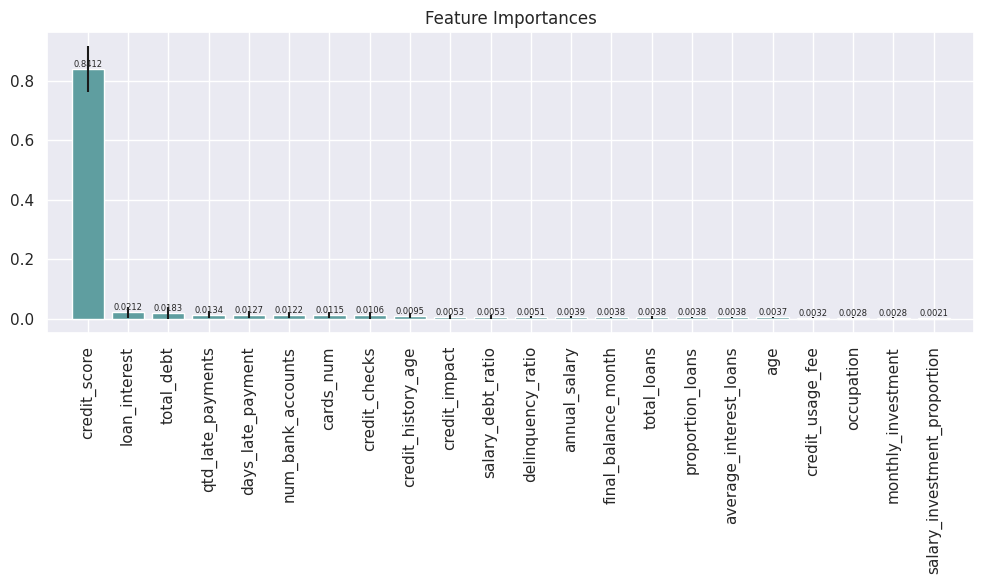

In [157]:
# Separando as features e a variável alvo
x_n = x  # As features
y_n = y  # A variável alvo

# Realizando o train-test split
x_train, x_test, y_train, y_test = train_test_split(x_n, y_n, test_size=0.2, random_state=42)

# Inicializando o modelo ExtraTreesClassifier
extra_trees = ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)
extra_trees.fit(x_train, y_train)  # Treinando apenas com o conjunto de treino

# Importâncias das Features
importances = extra_trees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extra_trees.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# Ranking das Features
print('Ranking:')
dataframe = pd.DataFrame()
for i, j in zip(x_train.columns, importances):  # Use x_train para manter a correspondência
    df_aux = pd.DataFrame({'Feature': i, 'Importance': j}, index=[0])
    dataframe = pd.concat([dataframe, df_aux], axis=0)

print(dataframe.sort_values('Importance', ascending=False))

# Plot
plt.figure(figsize=(10, 6))  # Tamanho da figura
plt.title('Feature Importances')
bars = plt.bar(range(x_train.shape[1]), importances[indexes], color='#5F9EA0', yerr=std[indexes], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[indexes], rotation=90)

# Adicionar números em cima de cada barra
for bar in bars:
    yval = bar.get_height()  # Obter a altura da barra
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=6)  # Adicionar texto

plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()  # Ajusta a layout para evitar sobreposição
plt.show()


## 7.3 - BEST FEATURES

In [158]:
best_features = ['age', 'occupation', 'annual_salary', 'num_bank_accounts', 'cards_num', 'loan_interest', 'days_late_payment', 
                  'qtd_late_payments', 'credit_checks', 'total_debt', 'credit_history_age', 'final_balance_month', 
                  'credit_score', 'proportion_loans','total_loans', 'average_interest_loans']

## 7.4 - TRAIN TEST SPLIT DATA

In [159]:
x = df7[best_features]
y = df7['status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


## 7.5 - HYPERPARAMETER FINE TUNNING

In [160]:
# Definir o modelo
knn = KNeighborsClassifier()

# Definir o grid de hiperparâmetros a serem testados
param_grid = {
    'n_neighbors': [5, 10, 20, 50, 100],
    'p': [1, 2],  # p=1: Manhattan, p=2: Euclidiana
    'weights': ['uniform', 'distance']  # Pesos dos vizinhos
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1', verbose=1)

# Realizar o ajuste fino (fit)
grid_search.fit(x_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores Hiperparâmetros: ", grid_search.best_params_)

# Avaliar o modelo otimizado
yhat_optimized = grid_search.predict(x_test)

# Métricas de avaliação
print('Acurracy: {}%'.format(np.round(accuracy_score(y_test, yhat_optimized), 2)*100))
print('Precision: {}%'.format(np.round(precision_score(y_test, yhat_optimized), 2)*100))
print('Recall: {}%'.format(np.round(recall_score(y_test, yhat_optimized), 2)*100))
print('F1: {}%'.format(np.round(f1_score(y_test, yhat_optimized), 2)*100))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores Hiperparâmetros:  {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Acurracy: 99.0%
Precision: 98.0%
Recall: 99.0%
F1: 99.0%


## 7.6 - CROSS VALIDATION

In [161]:
# Defina o número de vizinhos e a métrica de distância
knn = KNeighborsClassifier(n_neighbors=200, p=2, weights='distance')

# Defina os folds da validação cruzada (5 ou 10 folds são comuns)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Ou StratifiedKFold para classes desbalanceadas

# Definindo as métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Executando a validação cruzada para cada métrica
results = cross_val_score(knn, x_train, y_train, cv=kf, scoring='accuracy')
print('Cross-Validated Accuracy: {:.2f}%'.format(results.mean() * 100))

# Se quiser mais de uma métrica:
results_multi = cross_validate(knn, x_train, y_train, cv=kf, scoring=scoring)

# Ver as médias das métricas ao longo dos folds
print('Cross-Validated Accuracy: {:.2f}%'.format(results_multi['test_accuracy'].mean() * 100))
print('Cross-Validated Precision: {:.2f}%'.format(results_multi['test_precision'].mean() * 100))
print('Cross-Validated Recall: {:.2f}%'.format(results_multi['test_recall'].mean() * 100))
print('Cross-Validated F1: {:.2f}%'.format(results_multi['test_f1'].mean() * 100))


Cross-Validated Accuracy: 91.15%
Cross-Validated Accuracy: 91.15%
Cross-Validated Precision: 86.68%
Cross-Validated Recall: 98.51%
Cross-Validated F1: 92.22%


# 9.0 - MACHINE LEARNING MODEL

In [162]:
# Treinando o modelo final no conjunto completo
knn.fit(x_train, y_train)

# Avaliando no conjunto de teste
y_pred = knn.predict(x_test)
print('Final Model Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred) * 100))
print('Final Model Precision: {:.2f}%'.format(precision_score(y_test, y_pred) * 100))
print('Final Model Recall: {:.2f}%'.format(recall_score(y_test, y_pred) * 100))
print('Final Model F1: {:.2f}%'.format(f1_score(y_test, y_pred) * 100))

Final Model Accuracy: 92.73%
Final Model Precision: 88.93%
Final Model Recall: 98.57%
Final Model F1: 93.50%


# 10.0 - BUSINESS METRICS

In [163]:
credit_increase_proportion = 0.15

# Adicionar as previsões ao DataFrame de teste
x_test['predicted_status'] = y_pred

# Selecionar apenas os clientes com status = 1 (elegíveis para aumento de crédito)
eligible_clients = x_test[x_test['predicted_status'] == 1].copy()

# Reverter a transformação do salário anual ao seu valor original
eligible_clients['annual_salary_original'] = rs.inverse_transform(eligible_clients[['annual_salary']])

# Calcular o aumento de crédito proporcional ao salário anual original
eligible_clients['credit_increase'] = eligible_clients['annual_salary_original'] * credit_increase_proportion

# Definir a taxa de juros anual (por exemplo, 7%)
interest_rate = 0.07

# Calcular o lucro que a instituição financeira terá com o aumento de crédito
eligible_clients['credit_increase_profit'] = eligible_clients['credit_increase'] * interest_rate

# Calcular o lucro total com o aumento de crédito para todos os clientes elegíveis
total_profit = eligible_clients['credit_increase_profit'].sum()
total_profit_rounded = np.around(total_profit, 2)

# Exibir os resultados
print(eligible_clients[['annual_salary_original', 'credit_increase', 'credit_increase_profit']].head(10))

# Exibir o lucro total
print("\n Lucro total de aumentos de crédito: R$", total_profit_rounded)

       annual_salary_original  credit_increase  credit_increase_profit
80917               135178.44       20276.7660             1419.373620
27701                16096.54        2414.4810              169.013670
45080                19592.58        2938.8870              205.722090
16638                63756.33        9563.4495              669.441465
88702                43138.55        6470.7825              452.954775
63120                68474.64       10271.1960              718.983720
69161                41695.76        6254.3640              437.805480
19447                78569.90       11785.4850              824.983950
14888               133068.44       19960.2660             1397.218620
16821               107626.59       16143.9885             1130.079195

 Lucro total de aumentos de crédito: R$ 6631525.36


In [172]:
# Adicionar as previsões ao DataFrame de teste
x_test['predicted_status'] = y_pred

# Selecionar apenas os clientes com status = 1 (elegíveis para aumento de crédito)
eligible_clients = x_test[x_test['predicted_status'] == 1].copy()

# Reverter a transformação do salário anual ao seu valor original
eligible_clients['annual_salary_original'] = rs.inverse_transform(eligible_clients[['annual_salary']])

# Definir as proporções de aumento de crédito e as taxas de juros diretamente com base no 'credit_score'
eligible_clients['credit_increase_proportion'] = eligible_clients['credit_score'].map({
    3: 0.15,  # Good
    2: 0.12,  # Regular
    1: 0.05   # Bad
})

eligible_clients['interest_rate'] = eligible_clients['credit_score'].map({
    3: 0.07,  # Good
    2: 0.09,  # Regular
    1: 0.15   # Bad
})

# Calcular o aumento de crédito proporcional ao salário anual original
eligible_clients['credit_increase'] = eligible_clients['annual_salary_original'] * eligible_clients['credit_increase_proportion']

# Calcular o lucro que a instituição financeira terá com o aumento de crédito
eligible_clients['credit_increase_profit'] = eligible_clients['credit_increase'] * eligible_clients['interest_rate']

# Calcular o lucro total com o aumento de crédito para todos os clientes elegíveis
total_profit = eligible_clients['credit_increase_profit'].sum()
total_profit_rounded = np.around(total_profit, 2)

# Exibir os resultados
print(eligible_clients[['annual_salary_original', 'credit_increase', 'interest_rate', 'credit_increase_profit']].head(10))

# Exibir o lucro total
print("\n Lucro total de aumentos de crédito: $", total_profit_rounded)


       annual_salary_original  credit_increase  interest_rate  \
80917               135178.44        6758.9220           0.15   
27701                16096.54        1931.5848           0.09   
45080                19592.58        2351.1096           0.09   
16638                63756.33        3187.8165           0.15   
88702                43138.55        5176.6260           0.09   
63120                68474.64        8216.9568           0.09   
69161                41695.76        5003.4912           0.09   
19447                78569.90        9428.3880           0.09   
14888               133068.44       19960.2660           0.07   
16821               107626.59       12915.1908           0.09   

       credit_increase_profit  
80917             1013.838300  
27701              173.842632  
45080              211.599864  
16638              478.172475  
88702              465.896340  
63120              739.526112  
69161              450.314208  
19447              848.55492